In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json



2024-11-07 14:26:53.547117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#open data file
with open("data/holmes.txt", 'r', encoding='utf-8') as f:
  data = f.read()
  print(data[:500])

*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*

#4 in the Victor Appleton's Tom Swift Series

We name these Etext files as they are numbered in the books,

i.e. This is #4 in the series so the file name is 04tomxxx.xxx,

where the x's are place holders for editon # and file type such

as 04tom10.txt and 04tom10.zip, when we do a .htm, 04tom10h.htm





Copyright laws are changing all over the world, be sure to check

the copyright laws for your country before posting these files


In [3]:
#removal of special characters
def removeSpecialChar(data):
  #remove special characters
  data = re.sub(r'[^a-zA-Z0-9\s]', "", data)
  #remove extra spaces
  data = re.sub(" +", " ", data)

  
  return data
  

In [4]:
#Preprocessing
def preprocess(data):
  sentences = data.split("\n")
  for i in range(len(sentences)):
    sentences[i] = removeSpecialChar(sentences[i])
  
  sentences = [s.strip() for s in sentences]
  #drop empty sentences
  sentences = [ s for s in sentences if len(sentences)> 0]
  tokenizer = []
  for s in sentences:
    s = s.lower()
    tokenizer.append(s)
  return tokenizer

In [5]:
Tokenized_sentence = preprocess(data)

In [6]:
#Tokenize words
tokenizer = Tokenizer(oov_token ='<oov>')
tokenizer.fit_on_texts(Tokenized_sentence)
total_words = len(tokenizer.word_index) + 1


In [14]:
count =0
for idx, word  in enumerate(tokenizer.word_index):
  if count <=10:
    print(word, "-", idx)
    count +=1
  else:
    break


<oov> - 0
the - 1
and - 2
of - 3
to - 4
a - 5
in - 6
i - 7
he - 8
was - 9
that - 10


In [ ]:
#creating sequence
sequences = []
# for s in Tokenized_sentence:
#   list_ = tokenizer.texts_to_sequences([s])[0]
#   for i in range(1,len(list_)):
#     n_gram_seq = list_[:i+1]
#     sequences.append(n_gram_seq)
    
for s in Tokenized_sentence:
  if len(s) > 0:
    sequences.append(s)
print(sequences[:10])
    
sequences = tokenizer.texts_to_sequences(sequences)
    
#padding seq
max_seq_len = max([len(x) for x in sequences])
input_seq = np.array(pad_sequences(sequences, maxlen=max_seq_len, padding='pre'))

['project gutenbergs etext of tom swift and his submarine boat', '4 in the victor appletons tom swift series', 'we name these etext files as they are numbered in the books', 'ie this is 4 in the series so the file name is 04tomxxxxxx', 'where the xs are place holders for editon and file type such', 'as 04tom10txt and 04tom10zip when we do a htm 04tom10hhtm', 'copyright laws are changing all over the world be sure to check', 'the copyright laws for your country before posting these files', 'please take a look at the important information in this header', 'we encourage you to keep this file on your own disk keeping an']


In [9]:
input_seq

array([[   0,    0,    0, ...,  524, 2102, 2103],
       [   0,    0,    0, ..., 1573,    3,   18],
       [   0,    0,    0, ...,   10,  117,   61],
       ...,
       [   0,    0,    0, ...,  137,  356,  823],
       [   0,    0,    0, ...,    3,   96,    6],
       [   0,    0,    0, ...,   80,  335, 1570]], dtype=int32)

In [10]:
X , labels = input_seq[:,:-1], input_seq[:, -1]
Y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [11]:
Y.shape

(10386, 8730)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)



In [36]:

X_train.shape

(7270, 16)

In [37]:
X_train[1]

array([   0,    0,    0,    0,    0,    0,  729,   27,    4,   85,  569,
          5,   10,   11,   49, 1593], dtype=int32)

In [13]:
#LSTM model
model = Sequential()
model.add(Embedding(total_words,100))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
optimizer = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val,y_val), verbose=1)

Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.0462 - loss: 7.4017 - val_accuracy: 0.0789 - val_loss: 6.7745
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.0831 - loss: 5.7815 - val_accuracy: 0.0815 - val_loss: 6.8695
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.1437 - loss: 4.8343 - val_accuracy: 0.0905 - val_loss: 7.3298
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.2422 - loss: 3.8462 - val_accuracy: 0.0834 - val_loss: 7.7564
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.3851 - loss: 2.8747 - val_accuracy: 0.0764 - val_loss: 8.3970
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.5254 - loss: 2.1104 - val_accuracy: 0.0706 - val_loss: 8.8790
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.6351 - loss: 1.5659 - val_accuracy: 0.0623 - val_loss: 9.2560
Epoch 8/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7441 - loss: 1.1379 - 

In [14]:
#save the model
model = model.to_json()
with open("sentComLstm.json", 'w') as file:
  file.write(model)

In [15]:
with open("sentComLstm.json", 'r') as model_file:
  model_json = model_file.read()
  model = model_from_json(model_json)

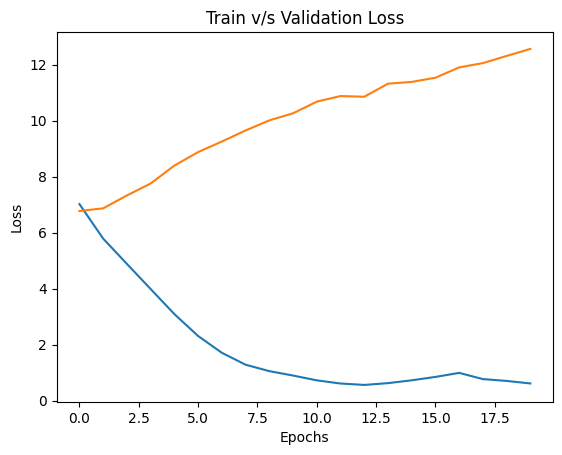

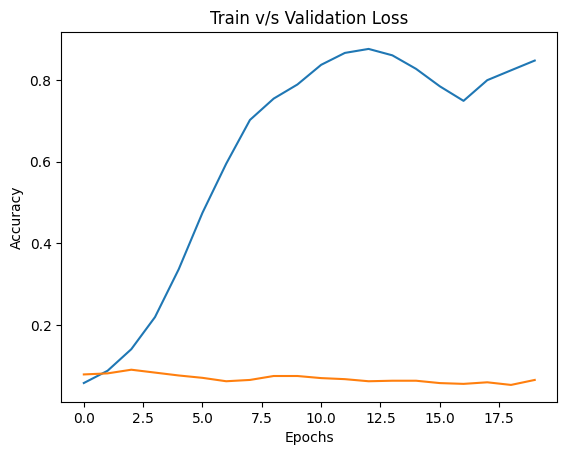

In [16]:

plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.title('Train v/s Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Validation_accuracy')
plt.title('Train v/s Validation Loss')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [61]:
def predict_next(model, query_text):
  query_text = np.reshape(query_text,(1,-1) )
  print(query_text.reshape)
  predict = model.predict(query_text, verbose =1)
  # print("prediction: ",predict)
  # print("predict[0]: ",predict[0])
  top_five_index = np.argsort(predict[0])[::-1][:5]
  print(top_five_index)
  top_words = []
  for i in top_five_index:
    for word, idx in tokenizer.word_index.items():
      if idx == i:
        top_words.append(word)
        break
  return top_words

In [57]:
def display_result(query_text):
  words = predict_next(model, query_text)
  results = []
  query = []
  for i in query_text:
    for word, idx in tokenizer.word_index.items():
      if idx == i and idx!=0:
        query.append(word)

  for word in words:
    results.append(f'{" ".join(query)}:  {word}')
  return results

In [55]:
def test(X, y):
  y_word = []
  for i in y:
      for word, idx in tokenizer.word_index.items():
        if idx == i and idx!=0:
          y_word.append(word)

  print(y_word)
  print('Expected result:'," ".join( y_word), "Observed result: ", display_result(X))
  

['<oov>']
<built-in method reshape of numpy.ndarray object at 0x00000280EF69BBD0>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
prediction:  [[0.0001146  0.00011441 0.00011485 ... 0.0001146  0.00011431 0.00011473]]
predict[0]:  [0.0001146  0.00011441 0.00011485 ... 0.0001146  0.00011431 0.00011473]
Expected result: <oov> Observed result:  ['closed the locket and handed it back to lord st:  gate', 'closed the locket and handed it back to lord st:  stoneflagged', 'closed the locket and handed it back to lord st:  indicated', 'closed the locket and handed it back to lord st:  depositors', 'closed the locket and handed it back to lord st:  sweet']


In [60]:
test(X_test[200],y_test[200])

['<oov>']
<built-in method reshape of numpy.ndarray object at 0x00000280EF6CD950>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
prediction:  [[0.0001147  0.00011426 0.00011474 ... 0.00011451 0.00011427 0.00011436]]
predict[0]:  [0.0001147  0.00011426 0.00011474 ... 0.00011451 0.00011427 0.00011436]
Expected result: <oov> Observed result:  ['well you have to be in the office or at least in:  mousseline', 'well you have to be in the office or at least in:  preserved', 'well you have to be in the office or at least in:  vainly', 'well you have to be in the office or at least in:  coldness', 'well you have to be in the office or at least in:  clotilde']
